**Abstract.**
I reached the point in my machine learning journey where I understood the basic concepts
(backpropagation, regularization, CNNs, RNNs, and transformers), but wanted to dig deeper.
The machine learning engineers that I knew suggested that I train a model for a problem I
found interesting. I selected learning regular expressions from examples as a toy problem.

# Generating training data

My plan for generating training data was:

1. Generate random regular expressions (regexes).
2. For each regex, generate some number of strings matching the regex.
3. For training data, let the $(x, y)$ input-output pairs be defined by:
   * $y$, a regex
   * $x$, a list of strings matching $y$, one per line
4. During training, reward if a forward pass through the network, starting with input $x$,
   produces an output $\hat{y}$ such that $y$ and $\hat{y}$ recognize the same strings.

## Imports

In [1]:
import os
import random
import graphviz
random.seed(42)

## Automata theory conversions

To work with regular expressions and finite automata, I started with
[Megha Bose's](https://github.com/Megha-Bose)
[Automata Theory Conversions](https://github.com/Megha-Bose/Automata-Theory-Conversions)
code. It wasn't licensed, so I asked her permission, and she gave me her
permission to use it.

## Generating random regexes

The following two problems did not seem like toy problems:

1. Creating a machine learning system capable of inferring long regexes.
2. Createing a machine learning system capable of inferring regexes with deep
   nestings of union and Kleene star operations.

Because I wanted a toy problem, I needed a way to generate short regexes having
shallow nestings. I settled on constructing a random parse tree having a
maximum depth.

In [2]:
# Union, Kleene star, concatenation, and grouping operations.
# '$' is special character that represents the empty string. 
# All other characters are considered symbols.
operators = ['+', '*', '.', '(', ')']


class OpType:
    """
    Constants for regular expression operator types.
    """
    SYMBOL = 1
    CONCAT = 2
    UNION  = 3
    KLEENE = 4


class ExpressionNode:
    """
    Node in an expression tree that represents the parse tree for a regular
    expression.
    """
    
    def __init__(self, op_type, value=None):
        self.op_type = op_type
        self.value = value
        self.left = None
        self.right = None

    def __str__(self):
        """
        Converts the node to a string in infix order, adding a lot of parens.
        """

        if self.op_type == OpType.SYMBOL:
            return self.value
        elif self.op_type == OpType.CONCAT:
            left = f'({self.left})' if self.left.op_type == OpType.UNION else str(self.left)
            right = f'({self.right})' if self.right.op_type == OpType.UNION else str(self.right)
            return left + right
        elif self.op_type == OpType.UNION:
            return f'{self.left}+{self.right}'
        elif self.op_type == OpType.KLEENE:
            if self.left.op_type == OpType.KLEENE:
                return str(self.left)
            elif self.left.op_type == OpType.SYMBOL:
                return str(self.left) + '*'
            else:
                return f'({self.left})*'
        else:
            raise Exception(f'unknown op type {self.op_type}')


def random_regex(max_depth=5, symbols="abcde", recurse_prob=0.95):
    """
    Generates a random regular expression.

    Args:
      max_depth: maximum depth of the parse tree
      symbols: allowed characters of the regular expression; must not contain 
               '$' nor any operator
      recurse_prob: probability that this method is invoked recursively

    Returns:
      expression tree representing the regular expression
    """

    can_recurse = max_depth > 1 and random.random() < recurse_prob

    op_type = random.randint(2, 4) if can_recurse else OpType.SYMBOL
    
    node = ExpressionNode(op_type)

    if op_type == OpType.SYMBOL:
        node.value = random.choice(symbols)
    else:
        node.left = random_regex(max_depth-1, symbols, recurse_prob)
        if op_type == OpType.CONCAT or op_type == OpType.UNION:
            node.right = random_regex(max_depth-1, symbols, recurse_prob)
        
    return node

In [3]:
for i in range(10):
    print(random_regex())

e*(bb+eb)((a+b)(c+b))*
de+a+e+(e+b)*+(b+c+d)(b+c+a*)
(e*+a+b)(be+b+d)(e*+e*)*
(bbb(e+a))*
e*
(c*(a+c)(c*+b))*
((cb)*+c*)(ea+a+e)b*d*
e
((e+d)*+eeaa)*
(d+b)e*(b+a)(c+d)a*


We've now generated random regexes, so we turn to generating strings matching a single regex.

## Generating strings matching a regex

To generate strings matching a regex, I first converted the regex into a non-deterministic
finite automaton (NFA), then followed random paths through the NFA from an initial node to
a terminal node.

### Step 1: rewrite regex (add concatenation, convert to postfix)

The first step in computing a regex to an NFA is to parse it. For this, it's useful to
rewrite the regex in a couple of ways:

1. Add concatenation symbols for convenience.
2. Convert the regex to postfix order.

In [4]:
def add_concat(regex):
    """
    Adds concatenation operators ('.') to the input regex for convenience.
    
    Args:
      regex: a string representing the regular expression
      
    Returns:
      a list representing the regular expression with added concatenation operators
    """
    
    global non_symbols

    result = []
    for i in range(len(regex) - 1):
        result.append(regex[i])
        if regex[i] not in operators:
            if regex[i + 1] not in operators or regex[i + 1] == '(':
                result += '.'
        elif regex[i] == ')' and regex[i + 1] == '(':
            result += '.'
        elif regex[i] == '*' and regex[i + 1] == '(':
            result += '.'
        elif regex[i] == '*' and regex[i + 1] not in operators:
            result += '.'
        elif regex[i] == ')' and regex[i + 1] not in operators:
            result += '.'

    result += regex[-1]
    return result

In [5]:
print(add_concat("ab*"))
print(add_concat("(ab)*"))
print(add_concat("(a+b)*c"))

['a', '.', 'b', '*']
['(', 'a', '.', 'b', ')', '*']
['(', 'a', '+', 'b', ')', '*', '.', 'c']


In [6]:
def compare_precedence(a, b):
    """
    Compares the precendence of the +, ., and * operators.
    
    Args:
      a: the first operator
      b: the second operator
      
    Returns:
      True iff a has precedence over b
    """
    p = ["+", ".", "*"]
    return p.index(a) > p.index(b)


def compute_postfix(regexp):
    """
    Converts an input regex to postfix order.
    
    Args:
      regex: list of regex operators and symbols
      
    Returns:
      list representing the regular expression in postfix order
    """
    
    stack = []
    result = []

    for c in regexp:
        if c not in operators or c == "*":
            result += c
        elif c == ")":
            while len(stack) > 0 and stack[-1] != "(":
                result += stack.pop()
            stack.pop()
        elif c == "(":
            stack.append(c)
        elif len(stack) == 0 or stack[-1] == "(" or compare_precedence(c, stack[-1]):
            stack.append(c)
        else:
            while len(stack) > 0 and stack[-1] != "(" and not compare_precedence(c, stack[-1]):
                result += stack.pop()
            stack.append(c)

    while len(stack) > 0:
        result += stack.pop()

    return result

In [7]:
print(compute_postfix(['a', '.', 'b']))
print(compute_postfix(['(', 'a', '.', 'b', ')']))
print(compute_postfix(['a', '.', 'b', '*']))
print(compute_postfix(['(', 'a', '.', 'b', ')', '*']))
print(compute_postfix(['(', 'a', '+', 'b', ')', '*', '.', 'c']))

['a', 'b', '.']
['a', 'b', '.']
['a', 'b', '*', '.']
['a', 'b', '.', '*']
['a', 'b', '+', '*', 'c', '.']


### Step 2: create expression tree from regex

Having converted the regex to postfix order, we create an expression tree from it. 

In [8]:
def make_expression_tree(regexp):
    """
    Makes an expression tree from a regex.
    
    Args:
      regex: a regular expression in postfix form
      
    Returns:
      an expression tree
    """
    
    stack = []

    for c in regexp:
        if c == "+":
            z = ExpressionNode(OpType.UNION)
            z.right = stack.pop()
            z.left = stack.pop()
            stack.append(z)
        elif c == ".":
            z = ExpressionNode(OpType.CONCAT)
            z.right = stack.pop()
            z.left = stack.pop()
            stack.append(z)
        elif c == "*":
            z = ExpressionNode(OpType.KLEENE)
            z.left = stack.pop() 
            stack.append(z)
        elif c == "(" or c == ")":
            continue  # just for safety; our input does not contain parens
        else:
            stack.append(ExpressionNode(OpType.SYMBOL, c))
    return stack[0]

In [9]:
print(make_expression_tree(['a', 'b', '.']))
print(make_expression_tree(['a', 'b', '*', '.']))
print(make_expression_tree(['a', 'b', '.', '*']))
print(make_expression_tree(['a', 'b', '+', '*', 'c', '.']))

ab
ab*
(ab)*
(a+b)*c


### Step 3: convert expression tree into a NFA

Having parsed the regex into a tree, we now convert the tree into a nondeterministic finite automaton (NFA).

We use `$` to denote the empty string; in textbooks $\epsilon$ normally denotes the empty string.

In [10]:
class NFAState:
    def __init__(self):
        self.next_state = {}

    def __str__(self):
        lines = ['NFAState ' + str(id(self))]
        for symbol, states in self.next_state.items():
            for state in states: 
                lines.append(f'\t{symbol}:\t{str(id(state))}')
        return '\n'.join(lines)

def compute_nfa(node):
    """
    Compute the NFA for an ExpressionNode.
    
    Args:
      node: an ExpressionNode
      
    Returns:
      the start and end NFAState for node
    """
    
    if node.op_type == OpType.CONCAT:
        left_nfa  = compute_nfa(node.left)
        right_nfa = compute_nfa(node.right)

        # '$' represents the empty string (usually denoted epsilon)
        left_nfa[1].next_state['$'] = [right_nfa[0]]
        return left_nfa[0], right_nfa[1]

    elif node.op_type == OpType.UNION:
        start = NFAState()
        end = NFAState()

        first_nfa = compute_nfa(node.left)
        second_nfa = compute_nfa(node.right)

        start.next_state['$'] = [first_nfa[0], second_nfa[0]]
        first_nfa[1].next_state['$'] = [end]
        second_nfa[1].next_state['$'] = [end]

        return start, end

    elif node.op_type == OpType.KLEENE:
        start = NFAState()
        end = NFAState()

        starred_nfa = compute_nfa(node.left)

        start.next_state['$'] = [starred_nfa[0], end]
        starred_nfa[1].next_state['$'] = [starred_nfa[0], end]
        
        return start, end

    elif node.op_type == OpType.SYMBOL:
        start = NFAState()
        end = NFAState()
        start.next_state[node.value] = [end]
        return start, end
    
    else:
        raise Exception(f'unknown op type {node.op_type}')

### Putting steps 1-3 together

We now wrap up steps 1-3 in a function that takes a regex as argument and returns an NFA.

In [11]:
def regex_to_nfa(regex):
    """
    Compute the NFA for a regular expression.
    
    Args:
      regex: a regular expression
    
    Returns:
      the start and end NFAState
    """
    
    concat = add_concat(regex)
    postfix = compute_postfix(concat)
    tree = make_expression_tree(postfix)
    start, end = compute_nfa(tree)
    return start, end

In [12]:
print(regex_to_nfa("ab*"))
print(regex_to_nfa("(ab)*"))
print(regex_to_nfa("(a+b)*c"))
print(regex_to_nfa(str(random_regex(6))))

(<__main__.NFAState object at 0x7fda2d6b9de0>, <__main__.NFAState object at 0x7fda2d6b9a50>)
(<__main__.NFAState object at 0x7fda2d6b9e10>, <__main__.NFAState object at 0x7fda2d6ba860>)
(<__main__.NFAState object at 0x7fda2d6b94b0>, <__main__.NFAState object at 0x7fda2d6b9ab0>)
(<__main__.NFAState object at 0x7fda2d6ba2f0>, <__main__.NFAState object at 0x7fda2d6bbc10>)


### Step 4: random paths through an NFA

Starting with an NFA, we've generated a regex. The next step is to generate strings matching
the regex from the NFA. To do that, we follow a random path through the NFA from the initial
node. We build the sequence of edge labels we see along the path traveled so far. When we reach
the terminal node, we output the edge labels we saw.

In [13]:
def nfa_path(start, end, max_steps):
    """
    Follow a random path through an NFA, accumulating edge labels.
    
    Args:
      start: start NFAState
      end: end NFAState
      
    returns:
      ':' followed by edge labels, or an empty string if no path
      to end state of at most max_steps steps was found
    """
    
    step = 0
    state = start
    found_path = False
    labels = []
    
    while step < max_steps:
        if state == end:
            found_path = True
            break
            
        # select random label
        i = random.randint(0, len(state.next_state) - 1)
        label = list(state.next_state)[i]
        if label != '$':
            labels.append(label)
        
        # select random next state
        i = random.randint(0, len(state.next_state[label]) - 1)
        state = state.next_state[label][i]
    
    if found_path:
        return ':' + ''.join(labels)
    else:
        return ''

In [14]:
regexes = ['ab*', '(ab)*', '(a+b)*c*', str(random_regex(4, 'abc'))]

for regex in regexes:
    print('regex', regex)
    start, end = regex_to_nfa(regex)
    for i in range(0, 10):
        print(nfa_path(start, end, 8))
    print('-----')

regex ab*
:abbbbb
:abbb
:a
:a
:ab
:ab
:abb
:abbbb
:a
:a
-----
regex (ab)*
:
:
:
:ab
:
:
:
:
:ab
:
-----
regex (a+b)*c*
:
:
:
:
:acc
:acc
:abc
:b
:c
:
-----
regex ba+b+c*+c
:
:ccc
:c
:b
:c
:c
:c
:c
:c
:c
-----


### Step 5: create training data

We now generate training data as files in a data directory. I decided to start
simple, with regexes having a maximum depth of 4.

In [15]:
def create_training_data(files, examples_per_file,
                         max_depth=4, symbols="abcdefghijklmnop",
                         recurse_prob=0.95):
    """
    Generate training data. Each file contains a regex and some strings
    matching the regex.

    Args:
      files: number of files to create
      examples_per_file: number of matching strings per file
      max_depth: see random_regex()
      symbols: see random_regex()
      recurse_prob: see random_regex()
    """
    
    os.mkdir('data')
    
    for i in range(files):
        with open(f'data/{i:06}.regex', 'x') as file:
            regex = str(random_regex(max_depth=max_depth, symbols=symbols,
                                     recurse_prob=recurse_prob))

            start, end = regex_to_nfa(regex)

            # choose a reasonable number of steps through the NFA.
            # empirically allowing max_steps = 4 * examples is enough
            # to frequently reach an accepting state
            max_steps = examples_per_file * 4
            
            for i in range(examples_per_file):
                path = ''
                # repeat until we find a path to an accepting state:
                while not path.startswith(':'):
                    path = nfa_path(start, end, max_steps)

                file.write(f'{path}\n')

            # indicate that no more examples follow with the prompt '>'
            file.write('>\n')

            # finally, write the regex
            file.write(f'{regex}\n')

I decided to generate one million regexes worth of training data. Empirically,
I found that when using the function `nfa_path()`, there were at most 900
unique strings generated per regex. It seemed reasonable to generate some
repeats, both to allow training to guess the structure of the regex, and to
allow `nfa_path()` to cover the NFA's structure. So I chose to generate 10,000
examples per file.

In [16]:
files = 1_000           # replace with: 1_000_000
examples_per_file = 10  # replace with: 10_000
create_training_data(files, examples_per_file)

And there we have it -- one million training files!

## Determining if two regexes are equivalent

We will need to define our loss function such that it rewards a prediction
$\hat{y}$ if $y$ and $\hat{y}$ recognize the same strings. How do we tell
whether two regexes recognize the same strings? The classic algorithm
has us do the following:

1. Convert $y$ and $\hat{y}$ to NFAs $N$ and $\hat{N}$.
2. Convert $N$ and $\hat{N}$ to deterministic finite automata (DFAs) $D$ and
   $\hat{D}$.
3. Use the table-filling algorithm to determine if the start states of $D$ and
   $\hat{D}$ are equivalent.

In this section, we develop the code necessary for steps 2 and 3. Step 1 was
already covered when we converted a regex to an NFA for the purpose of
generating strings matching the regex.

### Step 1: convert regex to NFA

Automata-Theory-Constructions already had code for this, which I modified a little (see `regex_to_nfa()`).

### Step 2: Convert NFA to DFA

To convert a nondeterministic finite automaton to a deterministic finite
automaton that recognizes the same language, we use the classic subset
construction. (A good description of the subset construction can be found in
M. Sipser, _Introduction to the Theory of Computation_).

We first write a function to compute the set of all NFA states reachable from
a given NFA state by following only transitions labeled with $\epsilon$, the
empty string. Recall that $\epsilon$ is represented by `$` in our code.

In [17]:
def epsilon_closure(states):
    """
    Compute the set of all states that can be reached from the given states by
    following only epsilon ($) transitions. 

    Args:
      states: iterable of NFAState
      visited: set of already visited states

    Returns:
      frozenset of states reachable from states by following only epsilon ($)
      transitions.
    """
    
    def helper(states, visited):    
        for state in states:
            if state not in visited:
                visited.add(state)
                try:
                    helper(state.next_state['$'], visited)
                except KeyError:
                    pass

    visited = set()
    helper(states, visited)
    
    return frozenset(visited)

To test `epsilon_closure()`, we use a couple of NFAs with $\epsilon$ transitions. The first is structured like this:

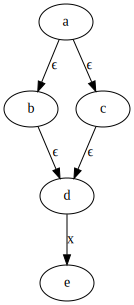

In [18]:
dot = graphviz.Digraph()
dot.node('a')
dot.node('b')
dot.node('c')
dot.node('d')
dot.node('e')
dot.edge('a', 'b', 'ϵ')
dot.edge('a', 'c', 'ϵ')
dot.edge('b', 'd', 'ϵ')
dot.edge('c', 'd', 'ϵ')
dot.edge('d', 'e', 'x')
dot

In [19]:
a = NFAState()
b = NFAState()
c = NFAState()
d = NFAState()
e = NFAState()

a.next_state['$'] = [b, c]
b.next_state['$'] = [d]
c.next_state['$'] = [d]
d.next_state['x'] = [e]

assert epsilon_closure([a]) == {a, b, c, d}

The second graph is structured as follows:

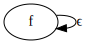

In [20]:
dot = graphviz.Digraph()
dot.edge('f', 'f', 'ϵ')
dot

In [21]:
f = NFAState()
f.next_state['$'] = [f]

assert epsilon_closure([f]) == {f}

Having written a function to compute the $\epsilon$-closure of a collection of
states, we now write a function that converts an NFA to a DFA. This is the
well-known subset construction. We find the reachable sets of states using
depth first search. Given a set of NFA states constituting a DFA state, and a
symbol, the search finds the set of NFA states reachable from the DFA state by
following the symbol.

Unlike many presentations of the subset construction, we don't compute the
power set of NFA states up front, and instead let search find the reachable DFA
states for us. We might avoid creating all $2^{|Q|}$ subsets of the NFA states
$Q$ in some cases (though in the worst case we will visit $\Omega(2^{|Q|})$
states). 

In [22]:
# A state in a deterministic finite automaton.
class DFAState:
    def __init__(self, is_accepting):
        self.is_accepting = is_accepting
        self.next_state = {}

    def __str__(self):
        lines = ['DFAState ' + str(id(self))]
        if self.is_accepting:
            lines.append('accepting')
        for symbol, state in self.next_state.items():
            lines.append(f'\t{symbol}:\t{str(id(state))}')
        return '\n'.join(lines)


# A deterministic finite automaton.
class DFA:
    def __init__(self, states, start, symbols):
        self.states = states
        self.start = start
        self.symbols = symbols

    def __str__(self):
        lines = []
        for state in self.states:
            lines.append('-----')
            lines.append(str(id(state)))
            if state == self.start:
                lines.append('start')
            if state.is_accepting:
                lines.append('accepting')
            for symbol, state in state.next_state.items():
                lines.append(f'\t{symbol}:\t{str(id(state))}')
        return '\n'.join(lines)


def nfa_to_dfa(start, end, symbols):
    """
    Convert an NFA to a DFA.

    Args:
      start: the start NFAState
      end: the end NFAState
      symbols: the alphabet of the NFA

    Returns:
      a DFA
    """

    def is_accepting(nfa_states):
        return any(s == end for s in nfa_states)
    
    dfa_states = {} # key: set of NFAState, value: DFAState
    nfa_states = {} # key: DFAState, value: set of NFAState

    closure = epsilon_closure([start])
    start_state = DFAState(is_accepting(closure))
    dfa_states[closure] = start_state
    nfa_states[start_state] = closure

    frontier = [start_state]
    visited = set()
    
    while len(frontier) > 0:
        state = frontier.pop()

        if state in visited:
            continue

        for symbol in symbols:
            # find NFA states reachable from state by following symbol
            reachable = set()

            for nfa_state in nfa_states[state]:
                try:
                    reachable.update(nfa_state.next_state[symbol])
                except KeyError:
                    pass

            reachable = epsilon_closure(reachable)
            
            if reachable in dfa_states:
                next = dfa_states[reachable]
            else:
                next = DFAState(is_accepting(reachable))
                dfa_states[reachable] = next
                nfa_states[next] = reachable
            
            state.next_state[symbol] = next
            
            if next not in visited:
                frontier.append(next)
        
        visited.add(state)
    
    return DFA(visited, start_state, symbols) 

In [23]:
regexes = ['a', 'b*']
symbols = ['a', 'b']

for i in range(len(regexes)):
    start, end = regex_to_nfa(regexes[i])
    dfa = nfa_to_dfa(start, end, symbols[i])
    print(f'DFA for {regexes[i]}:')
    print(str(dfa))

DFA for a:
-----
140575041566080
accepting
	a:	140575041558544
-----
140575041558544
	a:	140575041558544
-----
140575041565504
start
	a:	140575041566080
DFA for b*:
-----
140575041559216
accepting
	b:	140575041559216
-----
140575041564016
start
accepting
	b:	140575041559216


### Step 3: determine if two DFAs recognize the same strings

We first introduce a disjoint sets data structure based on the union-find algorithm.

In [24]:
# A disjoint sets data structure.
class UnionFind:
    def __init__(self, items):
        self.parent = {i: i for i in items}
        self.size = {i: 1 for i in items}

    def find(self, item):
        """
        Find the representative of an item.

        Args:
          item: the item for which the representative is wanted

        Returns:
          the representative of item
        """
        if self.parent[item] == item:
            return item
        else:
            parent = self.find(self.parent[item])
            self.parent[item] = parent
            return parent

    def union(self, item0, item1):
        """
        Merge two items.

        Args:
          item0 an item
          item1 another item (but could also be the same as item0)
        """
        find0 = self.find(item0)
        find1 = self.find(item1)
        if find0 == find1:
            return
        if self.size[find0] < self.size[find1]:
            find0, find1 = find1, find0
        self.parent[find1] = find0
        self.size[find0] += self.size[find1]

In [25]:
uf = UnionFind(range(6))

for i in range(6):
    for j in range(i):
        assert uf.find(i) != uf.find(j)

uf.union(0, 3)
uf.union(1, 4)
uf.union(2, 5)

for i in range(6):
    for j in range(6):
        assert (uf.find(i) == uf.find(j)) == (i % 3 == j % 3)

Next we write a function that determines if two DFA states $q_0$ and $q_1$ are
equivalent, in the sense that for all strings $s$, the state resulting from
following $s$ starting at $q_0$ is final if and only if the state resulting
from following $s$ starting at $q_1$ is final.

The algorithm for this is known as the "table-filling" algorithm. A good
description can be found in
[these lecture notes](https://people.csail.mit.edu/rrw/6.045-2020/lec5-color.pdf)
by Ryan Williams.

In [26]:
def equivalent_states(dfa):
    """
    Compute the equivalent states of a DFA.

    Args:
      dfa: a DFA

    Returns:
      a UnionFind such that find(state0) == find(state1) iff state0 and state1
      are equivalent
    """

    different = set()

    for s0 in dfa.states:
        for s1 in dfa.states:
            if s0 == s1:
                continue
            if s0.is_accepting ^ s1.is_accepting:
                different.add((s0, s1))
                different.add((s1, s0))

    stop = False

    while not stop:
        stop = True
        
        for s0 in dfa.states:
            for s1 in dfa.states:
                if s0 == s1 or (s0, s1) in different:
                    continue

                for symbol in dfa.symbols:
                    next0 = s0.next_state[symbol]
                    next1 = s1.next_state[symbol]
                    if (next0, next1) in different:
                        different.add((s0, s1))
                        different.add((s1, s0))
                        stop = False

    result = UnionFind(dfa.states)
    for s0 in dfa.states:
        for s1 in dfa.states:
            if (s0, s1) not in different:
                result.union(s0, s1)

    return result

We can use use our function that computes the equivalent states of a DFA to
also determine whether two DFAs are equivalent. The idea is to form a "union"
DFA $D = (Q_0 \cup Q_1, \Sigma, \delta_0 \cup \delta_1, -, F_0 \cup F_1)$,
then test whether $q_0$ and $q_1$ are equivalent in $D$. The start state
doesn't matter, hence the "$-$". The idea comes from
[these lecture notes by Ana Bove](https://www.cse.chalmers.se/edu/year/2012/course/TMV026/lec10.pdf).

In [27]:
def are_equivalent_dfas(dfa0, dfa1):
    """
    Determine whether two DFAs have the same language.

    Args:
      dfa0: a DFA
      dfa1: another DFA, which must have states disjoint from dfa0

    Returns:
      True iff dfa0 and dfa1 have the same language
    """

    if sorted(dfa0.symbols) != sorted(dfa1.symbols):
        return False
    
    states = set(dfa0.states)
    states.update(dfa1.states)

    # initial state does not matter (it could be anything)
    union = DFA(states, dfa0.start, dfa0.symbols)

    equiv = equivalent_states(union)

    return equiv.find(dfa0.start) == equiv.find(dfa1.start)

### Wrapping up steps 1-3

We finish up with a function to test the equivalence of two regular
expressions. First we write a function that extracts the symbols from a regular
expression.

In [28]:
def regex_to_symbols(regex):
    """
    Given a regular expression, return its symbols.

    Args:
      regex: a regular expression

    Returns:
      a string containing the symbols of regex
    """

    # split regex into single characters
    chars = set([*regex])

    # remove operators and convert to list
    nonoperators = list(chars - set(operators))

    # sort them
    nonoperators.sort()

    # join them into a string
    return "".join(nonoperators)

In [29]:
regexes0 = ['a*', '(a+b)*', 'a']
regexes1 = ['a**', '(a*+b*)*', 'b']
symbols = ['a', 'ab', 'ab']
answer = [True, True, False]

for i in range(len(regexes0)):
    start0, end0 = regex_to_nfa(regexes0[i])
    start1, end1 = regex_to_nfa(regexes1[i])
    dfa0 = nfa_to_dfa(start0, end0, regex_to_symbols(regexes0[i]))
    dfa1 = nfa_to_dfa(start1, end1, regex_to_symbols(regexes1[i]))
    assert are_equivalent_dfas(dfa0, dfa1) == answer[i]

Now, finally, we write a function that tests the equivalence of two regular
expressions.

In [30]:
def are_equivalent_regexes(regex0, regex1):
    """
    Determine whether two regular expressions recognize the same strings.

    Args:
      regex0: a regex
      regex1: also a regex

    Returns:
      True iff regex0 and regex1 recognize the same strings.
    """

    start0, end0 = regex_to_nfa(regex0)
    start1, end1 = regex_to_nfa(regex1)

    symbols0 = regex_to_symbols(regex0)
    symbols1 = regex_to_symbols(regex0)
    
    dfa0 = nfa_to_dfa(start0, end0, symbols0)
    dfa1 = nfa_to_dfa(start1, end1, symbols1)

    return are_equivalent_dfas(dfa0, dfa1)

### Appendix: minimizing DFAs

In this section I develop some code to minimize a DFA. I didn't need it for
determining the equivalence of regular expressions, but I initially thought I
would, and it seemed a shame to delete it.

DFA minimization typically requires pruning unreachable states. By
construction, the states in the DFAs constructed from NFAs in this notebook are
all reachable, so I didn't have to prune them.

In [31]:
def minimize(dfa):
    equiv = equivalent_states(dfa)

    states = {} # map from states of input DFA to states of minimized DFA
    
    for s in dfa.states:
        find = equiv.find(s)

        if find not in states:
            states[find] = DFAState(find.is_accepting)

        states[s] = states[find]

    done = set() # states of minimized DFA for which we have next states

    for old in dfa.states:
        new = states[old]
        if new not in done:
            new.next_state = {s: states[old.next_state[s]] for s in dfa.symbols}
            done.add(new)
    
    return DFA(done, states[dfa.start], dfa.symbols)

In [32]:
regexes = ['b*', '(a+b)*', '(a*+b*)*']
symbols = ['b', 'ab', 'ab']

for i in range(len(regexes)):
    start, end = regex_to_nfa(regexes[i])
    dfa = nfa_to_dfa(start, end, symbols[i])
    
    print(f'DFA for {regexes[i]}:')
    print(str(dfa))

    min = minimize(dfa)
    print(f'Minimized DFA for {regexes[i]}:')
    print(str(min))

DFA for b*:
-----
140575041566992
accepting
	b:	140575041566992
-----
140575041558736
start
accepting
	b:	140575041566992
Minimized DFA for b*:
-----
140575041566416
start
accepting
	b:	140575041566416
DFA for (a+b)*:
-----
140575041567232
accepting
	a:	140575041567232
	b:	140575041562480
-----
140575041559648
start
accepting
	a:	140575041567232
	b:	140575041562480
-----
140575041562480
accepting
	a:	140575041567232
	b:	140575041562480
Minimized DFA for (a+b)*:
-----
140575041563296
start
accepting
	a:	140575041563296
	b:	140575041563296
DFA for (a*+b*)*:
-----
140575040982800
start
accepting
	a:	140575041567280
	b:	140575041568288
-----
140575041568288
accepting
	a:	140575041567280
	b:	140575041568288
-----
140575041567280
accepting
	a:	140575041567280
	b:	140575041568288
Minimized DFA for (a*+b*)*:
-----
140575040989376
start
accepting
	a:	140575040989376
	b:	140575040989376
